Importamos todas las librerías necesarias

In [ ]:
!pip install stop_words

  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=ef972598d968d9e19b0c0af3411fd3fa5674dfe61894bab1981973e133afcbb3
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [ ]:
import pandas as pd
import os
from collections import Counter
import matplotlib.pyplot as plt
import string
from stop_words import get_stop_words
import string
from google.colab import drive
from nltk import ngrams
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.cm as cm

Conectamos al drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
datasets_path = 'drive/MyDrive/bases_de_datos'
data_json = 'Cell_Phones_and_Accessories_5.json'
df_cellphones = pd.read_json(os.path.join(datasets_path, data_json), lines=True)


Creamos un dataframe con las columnas de reseña y nota 

In [ ]:
df_cellphones = df_cellphones.dropna(subset=['reviewText', 'overall'])[['reviewText', 'overall']]
df_cellphones.head()

,reviewText,overall
0,They look good and stick good! I just don't li...,4
1,These stickers work like the review says they ...,5
2,These are awesome and make my phone look so st...,5
3,Item arrived in great time and was in perfect ...,4
4,"awesome! stays on, and looks great. can be use...",5


Vamos a ver cuantas notas hay de cada y cuál es la más común

In [ ]:
rates = Counter(df_cellphones.overall)

In [ ]:
rates_most_common = rates.most_common(10)
grades = [r[0] for r in rates_most_common]
freqs = [r[1] for r in rates_most_common]

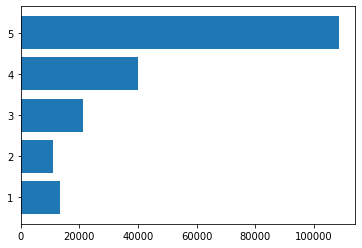

In [ ]:
plt.barh(grades, freqs)
plt.show()

Vamos a crear una tercera columna con el valor de sentimiento, este será un 0 si la nota es 3 o menor y un 1 si es mayor

In [ ]:
df_cellphones.loc[:, 'sentiment'] = [0 if rank <= 3 else 1 for rank in df_cellphones['overall']]
df_cellphones.head()

,reviewText,overall,sentiment
0,They look good and stick good! I just don't li...,4,1
1,These stickers work like the review says they ...,5,1
2,These are awesome and make my phone look so st...,5,1
3,Item arrived in great time and was in perfect ...,4,1
4,"awesome! stays on, and looks great. can be use...",5,1


Vemos cuántas hay de cada valor de sentimiento

In [ ]:
sentimiento = Counter(df_cellphones.sentiment)
sentimiento


Counter({0: 45782, 1: 148657})

Comenzamos con el tratamiento de texto, para ello commenzamos creando una lista con las frases convertidas a minúsculas y separando las palabras en más listas

In [ ]:
reviewtext = df_cellphones.reviewText.str.lower().str.strip().str.split()

In [ ]:
reviewtext

0         [they, look, good, and, stick, good!, i, just,...
1         [these, stickers, work, like, the, review, say...
2         [these, are, awesome, and, make, my, phone, lo...
3         [item, arrived, in, great, time, and, was, in,...
4         [awesome!, stays, on,, and, looks, great., can...
                                ...                        
194434    [works, great, just, like, my, original, one.,...
194435    [great, product., great, packaging., high, qua...
194436    [this, is, a, great, cable,, just, as, good, a...
194437    [i, really, like, it, becasue, it, works, well...
194438    [product, as, described,, i, have, wasted, a, ...
Name: reviewText, Length: 194439, dtype: object

Vamos a quitar todos los signos de puntuación y las stop_words para poder realizar un mejor análisis

In [ ]:
table = str.maketrans('', '', string.punctuation)
listapalabras=[]
stop_list = get_stop_words('en')
for sentence in reviewtext:
  for word in sentence:
    if word not in stop_list:
      word2 = word.translate(table)
      if word2 != '':
        listapalabras.append(word2)

Vemos el total de palabras distintas y cuáles son las más comunes de ellas

En total hay 218846 palabras tras quitar las stop_words


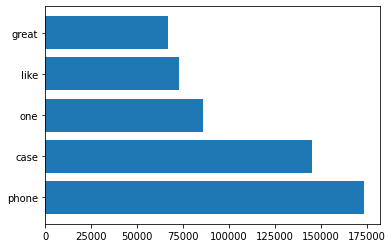

In [ ]:
print(f'En total hay {len(Counter(listapalabras))} palabras tras quitar las stop_words')
words_most_common = Counter(listapalabras).most_common(5)
words = [w[0] for w in words_most_common]
freqs = [w[1] for w in words_most_common]
plt.barh(words, freqs)
plt.show()

Vamos a estudiar las tuplas y trios más comunes que podemos encontrar en nuestra lista de palabras extraídas de las reseñas

In [ ]:
bigrams_ = list(ngrams(listapalabras, 2))
trigrams_ = list(ngrams(listapalabras, 3))

In [ ]:
bg_freq = FreqDist(bigrams_)
tg_freq = FreqDist(trigrams_)

In [ ]:
bg_freq.most_common(10)

[(('screen', 'protector'), 17215),
 (('iphone', '5'), 7477),
 (('screen', 'protectors'), 6680),
 (('works', 'great'), 6642),
 (('battery', 'life'), 6391),
 (('samsung', 'galaxy'), 6196),
 (('phone', 'case'), 6081),
 (('works', 'well'), 5245),
 (('cell', 'phone'), 4952),
 (('sound', 'quality'), 4923)]

In [ ]:
tg_freq.most_common(10)

[(('samsung', 'galaxy', 's3'), 1076),
 (('samsung', 'galaxy', 'note'), 1022),
 (('samsung', 'galaxy', 's4'), 999),
 (('galaxy', 'note', '2'), 926),
 (('micro', 'usb', 'cable'), 851),
 (('get', 'pay', 'for'), 825),
 (('galaxy', 'note', '3'), 770),
 (('fits', 'phone', 'perfectly'), 613),
 (('really', 'like', 'case'), 590),
 (('highly', 'recommend', 'product'), 579)]

Vamos a realizar una nube de palabras en las que podremos ver cuales son las más comunes

In [ ]:
def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(text))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

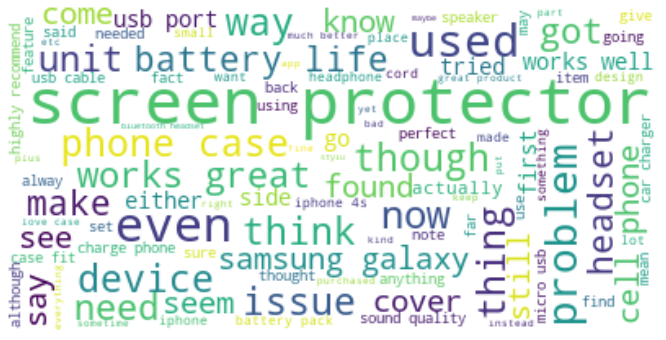

In [ ]:
plot_word_cloud(listapalabras)

Como se puede observar en la nube las palabras más comunes vendrían a ser screen y protector lo que está altamente relacionado con el tema escogido.

Comenzamos la visualización en 2 dimensiones de algunos word embeddings calculados con Word2Vec. Para ello vamos a seleccionar una muestra de 2000 reseñas para no sobresaturar el cálculo.

In [ ]:
w2v_params = {
    'sg': 1,
    'size': 300,
    'min_count': 5,
    'window': 5,
    'hs': 0,
    'negative': 20,
    'workers': 4
}
corpus = df_cellphones.reviewText.sample(2000)
corpus= corpus.str.split()

In [ ]:
 w2v_model = Word2Vec(**w2v_params)

In [ ]:
 w2v_model.build_vocab(corpus)

Entrenamos el modelo

In [ ]:
w2v_model.train(sentences=corpus, total_examples=w2v_model.corpus_count, epochs=20)

(2379600, 3782700)

Lo guardamos

In [ ]:
w2v_model.save('drive/MyDrive/model/w2v_model.pkl')


In [ ]:
def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), 
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.title('Representación en 2D de los embeddings de algunos clusters de palabras')
    plt.show()

Se han escogido estas palabras como keys al tratarse de las más comunes como hemos podido observar en la nube de palabras

In [ ]:
keys = ['screen', 'protector', 'device']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2v_model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [ ]:
tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)

In [ ]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

In [ ]:
 embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


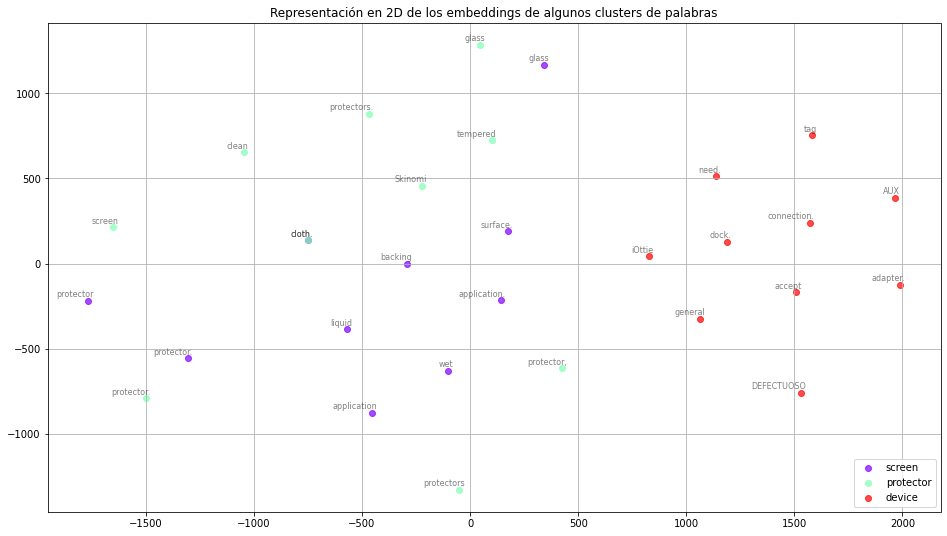

In [ ]:
tsne_plot_similar_words(keys, embeddings_2d, word_clusters)